In [14]:
import pandas as pd
import numpy as np
#data visualization
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split

from scipy.stats import kurtosis
from scipy.stats import skew

pd.options.display.precision = 10

## Umgebungsvariablen

In [15]:
#feature generated 24.03.2019
earthquake_daten = '''C:/studium/studium/CAS_PML/Projekt_Arbeit/earthquake/Daten/earthquake_data/'''
feature_62900_94 = 'Features_62900-94.csv'
feature_41934_94 = 'Features_41934_94.csv'
Features_4194_94 = 'Features_4194_94.csv'

# Feature laden

In [16]:
train_data = pd.read_csv(earthquake_daten+Features_4194_94 )

In [17]:
train_data_reduced = train_data.filter(items=['spec_cent_75%q',
 'min',
 'mean',
 'max',
 'zero_crossings',
 'skew',
 'absMax',
 'rolloff_min',
 'chroma_stft_std',
 'kurt',
 'spec_cent_min',
 'spec_cent_95%q',
 'spec_bw_min',
 'spec_bw_75%q',
 'rolloff_75%q',
 'chroma_stft_skew',
 'chroma_stft_mean',
 'psd_skew',
 'chroma_stft_min',
 'chroma_stft_kurt',
 'psd_75%q',
 'psd_kurt',
 'rolloff_max',
 'psd_25%q',
 'chroma_stft_75%q',
 'spec_cent_max',
 'rolloff_95%q',
 'spec_cent_99%q',
 'psd_max',
 'spec_bw_99%q',
 'spec_bw_95%q',
 'absMean',
 'spec_bw_25%q',
 'chroma_stft_25%q',
 'spec_bw_max',
 'rolloff_99%q',
 'spec_cent_25%q',
 'psd_5%q',
 'spec_bw_kurt',
 'spec_cent_std',
 'time_to_failure'])

In [6]:
train_data_reduced

,mean,kurt,skew,min,max,absMax,rms_kurt,zero_crossings,spec_cent_max,spec_cent_75%q,...,psd_skew,psd_min,psd_5%q,psd_25%q,psd_75%q,chroma_stft_skew,chroma_stft_75%q,spec_bw_max,spec_bw_99%q,time_to_failure
0,4.8841133333,33.6624812935,-0.0240611666,-98,104,104,-1.9144601086,11112,779718.3984031264,733159.4642193337,...,4.6738462448,0.0000005522,0.0000011604,0.0000018106,0.0000051602,0.3649612855,0.9961892727,593848.0949585186,589247.3423812583,1.4307971859
1,4.8460000000,107.6590450983,0.3925487681,-154,181,181,-1.8409455737,10896,779399.3470904609,736612.5134613134,...,3.4562442303,0.0000005446,0.0000011645,0.0000017895,0.0000052140,-11.1282768673,0.9960143764,591835.0083446358,589359.9034747409,1.4265987083
2,4.8111600000,110.4614763269,0.4131461554,-154,181,181,-1.5016621047,11002,780546.9703317202,737973.7808192460,...,3.2419593334,0.0000005454,0.0000011569,0.0000018018,0.0000052309,-10.8530496921,0.9961938217,593958.4716608603,588331.0470630293,1.4233957251
3,4.7970666667,102.2839738481,0.3948502125,-154,181,181,-1.2350759527,11102,780605.6109377267,737384.8299326156,...,3.1993029118,0.0000005687,0.0000011523,0.0000018470,0.0000052344,-9.9423065072,0.9963601540,594248.5566511984,588848.0485897590,1.4190972475
4,4.7963466667,112.5711765807,0.4967878159,-154,181,181,-1.2788991843,11492,779109.7670845632,731781.3140465751,...,4.6201453209,0.0000005564,0.0000011548,0.0000018333,0.0000052794,-10.3648509485,0.9960155736,592701.6014523738,589839.5361300857,1.4148987699
5,4.7468000000,116.7973773321,0.5262835844,-154,181,181,-0.5774606448,11636,779920.4205089794,733022.9480336552,...,4.6681265831,0.0000005612,0.0000011525,0.0000018126,0.0000053474,-10.9802361409,0.9961443815,588562.5789583060,587648.3018587903,1.4116957867
6,4.6994800000,121.1774211473,0.5483851759,-154,181,181,-0.8976221564,12010,780864.2537622817,735044.9077362029,...,4.7959561348,0.0000005783,0.0000011658,0.0000017823,0.0000054390,-9.9183035736,0.9961653986,589273.4860798966,588501.8430282404,1.4073973091
7,4.6708066667,119.0756687337,0.5454550608,-154,181,181,4.8111239677,12018,778700.7052224836,741800.7075610617,...,4.8711395264,0.0000005859,0.0000011787,0.0000017620,0.0000054626,-10.0642281240,0.9960328049,593734.3241384465,590020.7735442645,1.4031988315
8,4.6721066667,109.7625364137,0.5220375578,-154,181,181,-0.4968991228,12158,783123.2757242788,738663.6241551940,...,4.6835293770,0.0000005750,0.0000011802,0.0000017480,0.0000054124,-10.9486988733,0.9959968156,593102.0938234257,589749.6821766989,1.3999958483
9,4.6939133333,98.8830141106,0.4001103613,-154,181,181,0.4285155647,12258,780526.8337437779,736046.6518060918,...,4.8384962082,0.0000005653,0.0000011658,0.0000017576,0.0000054005,-10.4783934568,0.9961749782,590411.2824687082,589775.6536705673,1.3956973707


## Testdaten vorbereiten

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data_reduced.iloc[:,0:40], train_data_reduced.iloc[:,-1], random_state=0, test_size=0.25)

# Create Model Workbench

## Imports

In [19]:
# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Model selection
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# Modell
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor, Pool
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# GradientBoost

## Einleitung

boosting controls both the aspects (bias & variance). It combines a set of weak learners and delivers improved prediction accuracy.

The overall parameters can be divided into 3 categories:

  -  Tree-Specific Parameters: These affect each individual tree in the model.
    -  min_samples_split:  
  -  Boosting Parameters: These affect the boosting operation in the model.
  -  Miscellaneous Parameters: Other parameters for overall functioning.
  
  
  Quelle:
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

Pipe with preprocessing and one regressor

In [20]:
pipe = Pipeline([('preprocessing',PolynomialFeatures()), ('regressor', GradientBoostingRegressor())])

In [21]:
param_grid = [
    {'regressor': [GradientBoostingRegressor(n_estimators=80, learning_rate=0.1, random_state=0)],
     'regressor__loss':['lad','ls'],
     'regressor__max_depth':[1,3,5],
     'regressor__learning_rate':[0.1,0.05,0.2],
     'preprocessing': [None]}]

Find best parameter with grid search

In [22]:
grid = GridSearchCV(pipe, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessing', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('regressor', GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_...one, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'regressor': [GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
     ...se)], 'regressor__loss': ['lad', 'ls'], 'regressor__max_depth': [1, 2, 3], 'preprocessing': [None]}],
       pre_dispatch='2*n_jobs', refit

Print Result

In [23]:
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Test-set score: {:.2f}".format(grid.score(X_test, y_test)))
print("Test-set: mean absolute error : {:.2f}".format(mean_absolute_error(y_test, grid.predict(X_test))))

Best params:
{'preprocessing': None, 'regressor': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, n_iter_no_change=None, presort='auto',
             random_state=0, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False), 'regressor__loss': 'ls', 'regressor__max_depth': 3}

Best cross-validation score: -1.85
Test-set score: -1.81
Test-set: mean absolute error : 1.81


## Feature Importence

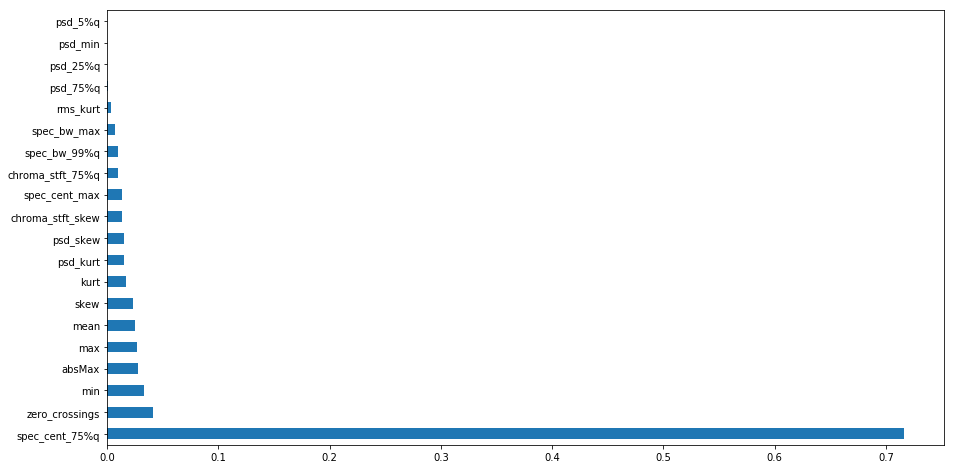

In [24]:
(pd.Series(grid.best_estimator_.named_steps['regressor'].feature_importances_, index=X_train.columns)
   .nlargest(26)
   .plot(kind='barh',figsize=(15, 8))) 
#quelle: https://stackoverflow.com/questions/44511636/matplotlib-plot-feature-importance-with-feature-names

## Model selection
 - Random forrest
 - Other GradientBoost (AdaBoost)

 - Feed Forward NN (with Karas)
 - Reccurent Neuronal Net: LSTM (with Karas)
 - Convolutional NN https://www.kaggle.com/michael422/spectrogram-convolution https://www.kaggle.com/michael422/spectrogram-convolution
 
 
 - CatBoost vs. Light GBM vs. XGBoost https://www.kdnuggets.com/2018/03/catboost-vs-light-gbm-vs-xgboost.html
 - CatBoost-GridSearch https://setscholars.net/2019/02/19/how-to-find-optimal-parameters-for-catboost-using-gridsearchcv-for-regression-in-python/